In [5]:
from collections import namedtuple

import jax
import matplotlib.pyplot as plt
import numpy as np
from models import CatCNOT, CrossResonanceGate, DrivenCavity


def is_gpu_available() -> bool:
    return any('cuda' in str(device) for device in jax.devices())


Benchmark = namedtuple('Benchmark', ['shortlabel', 'label', 'model', 'repeat'])

## Benchmark all models with fixed Hilbert space size

In [17]:
# init models
benchmarks = [
    Benchmark('drivencav', 'Driven cavity\n(N=128)', DrivenCavity(), 7),
    Benchmark('crgate', 'Cross-resonance gate\n(N=4)', CrossResonanceGate(), 7),
    Benchmark('catcnot16', 'CatCNOT\n(N=256)', CatCNOT(N=16), 3),
    # Benchmark('catcnot32', 'CatCNOT\n(N=1024)', CatCNOT(N=32), 1),
]

# compute speedups for each model
speedups = []
for bench in benchmarks:
    print(f'Running benchmark for {bench.shortlabel}')  # noqa: T201

    # check qutip and dynamiqs models are equal
    bench.model.check_args()

    # benchmark models
    timer_qutip_cpu = bench.model.benchmark('qutip', 'cpu', repeat=bench.repeat)
    timer_dynamiqs_cpu = bench.model.benchmark('dynamiqs', 'cpu', repeat=bench.repeat)
    if is_gpu_available():
        timer_dynamiqs_gpu = bench.model.benchmark(
            'dynamiqs', 'gpu', repeat=bench.repeat
        )

    # store results
    speedup_cpu = timer_qutip_cpu / timer_dynamiqs_cpu
    if is_gpu_available():
        speedup_gpu = timer_qutip_cpu / timer_dynamiqs_gpu
        speedups.append((1.0, speedup_cpu, speedup_gpu))
    else:
        speedups.append((1.0, speedup_cpu))

Running benchmark for drivencav
Running benchmark for crgate
Running benchmark for catcnot16


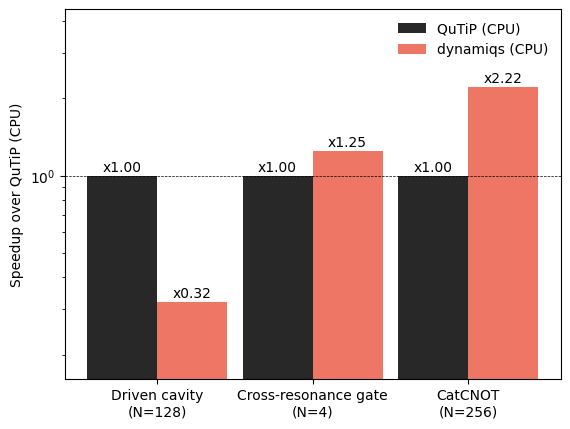

In [26]:
# prepare plot formatting
model_labels = [bench.label for bench in benchmarks]
groups = np.arange(len(benchmarks))

if is_gpu_available():
    labels = ['QuTiP (CPU)', 'dynamiqs (CPU)', 'dynamiqs (GPU)']
    colors = ['#282828', '#ed7764', '#8e473c']
    width = 0.3
else:
    labels = ['QuTiP (CPU)', 'dynamiqs (CPU)']
    colors = ['#282828', '#ed7764']
    width = 0.45

# create plot
fig, ax = plt.subplots()
ax.axhline(1.0, 0, len(benchmarks), color='k', linestyle='--', lw=0.5)

for i, (label, color) in enumerate(zip(labels, colors)):
    offset = i * width
    speedup = [speedup[i] for speedup in speedups]
    rects = ax.bar(groups + offset, speedup, width, color=color, label=label)
    ax.bar_label(rects, padding=1, fmt='x%.2f')

ax.legend(frameon=False)
ax.set_ylabel('Speedup over QuTiP (CPU)')
ax.set_xticks(groups + (len(benchmarks) - 0.5) * width, model_labels)
ax.set_yscale('log')
ax.set_ylim((0.5 * np.min(speedups), 2 * np.max(speedups)))
plt.show()

## Sweep Hilbert space size on a single model

In [14]:
model_class = DrivenCavity
sizes = 2 ** np.arange(4, 11, dtype=int)
benchmarks = [
    Benchmark(
        f'N={size}', f'{model_class.__name__}\n(N={size})', model_class(N=int(size)), 7
    )
    for size in sizes
]
timers = []

for bench in benchmarks:
    print(f'Running benchmark for {bench.shortlabel}')  # noqa: T201

    # check qutip and dynamiqs models are equal
    bench.model.check_args()

    # benchmark models
    timer_qutip_cpu = bench.model.benchmark('qutip', 'cpu', repeat=bench.repeat)
    timer_dynamiqs_cpu = bench.model.benchmark('dynamiqs', 'cpu', repeat=bench.repeat)
    if is_gpu_available():
        timer_dynamiqs_gpu = bench.model.benchmark(
            'dynamiqs', 'gpu', repeat=bench.repeat
        )

    # store results
    if is_gpu_available():
        timers.append([timer_qutip_cpu, timer_dynamiqs_cpu, timer_dynamiqs_gpu])
    else:
        timers.append([timer_qutip_cpu, timer_dynamiqs_cpu])

timers = np.asarray(timers)

Running benchmark for N=16
Running benchmark for N=32
Running benchmark for N=64
Running benchmark for N=128
Running benchmark for N=256
Running benchmark for N=512
Running benchmark for N=1024


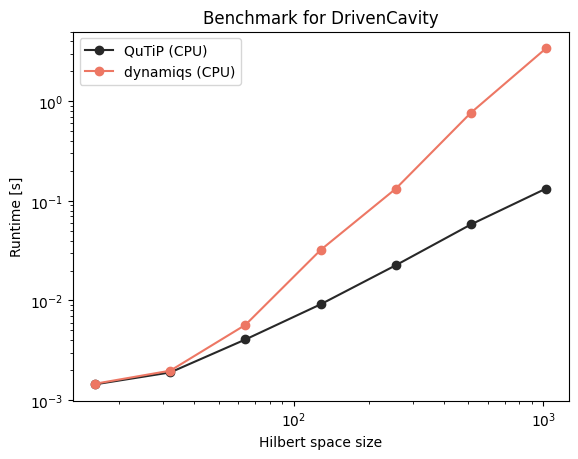

In [15]:
# prepare plot formatting
if is_gpu_available():
    labels = ['QuTiP (CPU)', 'dynamiqs (CPU)', 'dynamiqs (GPU)']
    colors = ['#282828', '#ed7764', '#8e473c']
else:
    labels = ['QuTiP (CPU)', 'dynamiqs (CPU)']
    colors = ['#282828', '#ed7764']

# create plot
fig, ax = plt.subplots()
for i, (label, color) in enumerate(zip(labels, colors)):
    ax.plot(sizes, timers[:, i], 'o-', label=label, color=color)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Hilbert space size')
ax.set_title(f'Benchmark for {model_class.__name__}')
ax.legend()
plt.show()